# Проект Промышленность

Для оптимизации производственных расходов необходимо уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, предсказывающую температуру стали.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy. stats import pearsonr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy import stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

r_state = 110923

In [2]:
try:
    data_arc_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('C:/Users/user/DS_ya/datasets/data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

## Анализ исходных данных

### Данные об электродах:

In [3]:
#data_arc_new.csv — данные об электродах
print('Общая информация:')
data_arc_new.info()
display(data_arc_new.head())
print()
print('Уникальные значения в столбце key:')
display(data_arc_new['key'].unique())
print('Уникальных значений в столбце key:', data_arc_new['key'].nunique())

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Уникальные значения в столбце key:


array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

Уникальных значений в столбце key: 3214


В датасете приведены данные по 3214 партиям. 

Пропусков в данных нет

In [4]:
print(data_arc_new['Начало нагрева дугой'].describe())
print()
print(data_arc_new['Конец нагрева дугой'].describe())
print()
print(data_arc_new['Активная мощность'].describe())
print()
print(data_arc_new['Реактивная мощность'].describe())

count                   14876
unique                  14876
top       2019-05-03 11:02:14
freq                        1
Name: Начало нагрева дугой, dtype: object

count                   14876
unique                  14876
top       2019-05-03 11:06:02
freq                        1
Name: Конец нагрева дугой, dtype: object

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64


Графики распределения параметров в таблице data_arc_new:
По оси Х отложено значение параметра, указанного в заголовке
По оси У количество значений


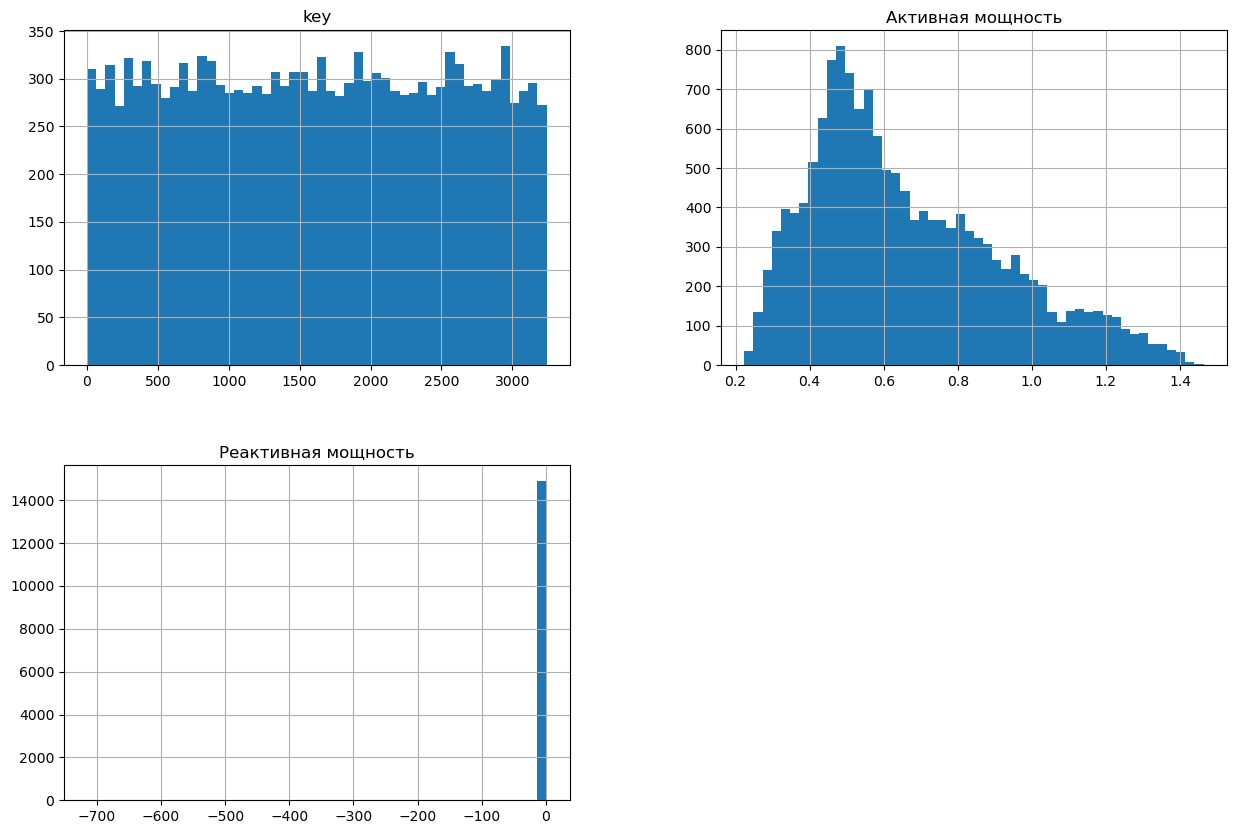

In [5]:
print('Графики распределения параметров в таблице data_arc_new:')
print('По оси Х отложено значение параметра, указанного в заголовке')
print('По оси У количество значений')
data_arc_new.hist(figsize=(15, 10), bins=50)
plt.show()

Датасет data_arc_new. В столбце реактивная мощность есть отрицательные значения. Либо удаляем всю партию, либо используем только активную мощность, либо из активной восстанавливаем реактивную.

В дальнейшем: создать столбец длительность нагрева, посчитать энергию из мощности и длительности.

### Данные о подаче сыпучих материалов (объём)

In [6]:
#data_bulk_new.csv — данные о подаче сыпучих материалов (объём)
print('Общая информация')
data_bulk_new.info()
display(data_bulk_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_bulk_new['key'].unique())
print('Уникальных значений в столбце key:', data_bulk_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3129


Графики распределения параметров в таблице data_bulk_new:
По оси Х отложено значение параметра, указанного в заголовке
По оси У количество значений


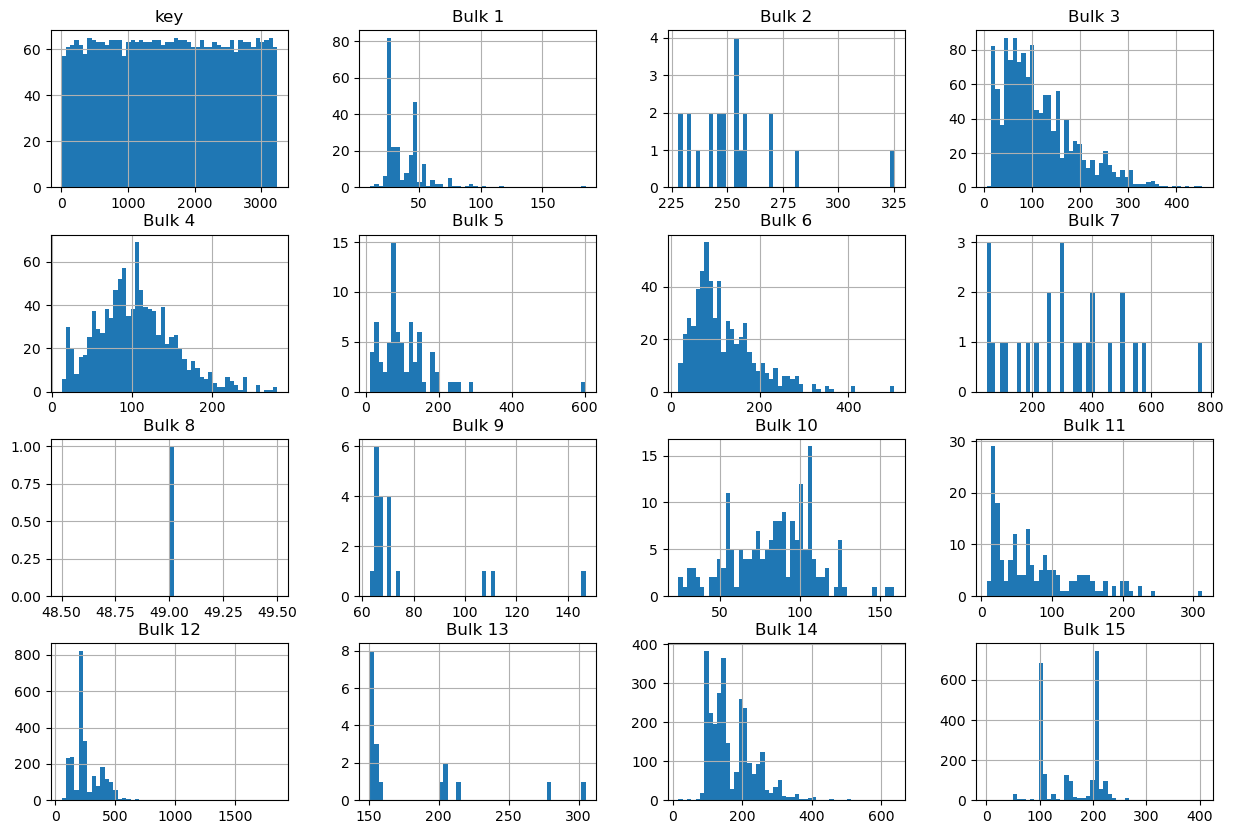

In [7]:
print('Графики распределения параметров в таблице data_bulk_new:')
print('По оси Х отложено значение параметра, указанного в заголовке')
print('По оси У количество значений')
data_bulk_new.hist(figsize=(15, 10), bins=50)
plt.show()

Содержатся данные об объеме добавленного материала для каждой партии (всего 15 типов добавок). Пропуск обозначает, что материал не добавлялся, заменим нулем. Чаще всего добавляются №№ 3,4,6,12,14

В дальнейшем можно удалить данные с низкими значениями


### Данные о подаче сыпучих материалов (время)

In [8]:
#data_bulk_new.csv — данные о подаче сыпучих материалов (время)
print('Общая информация')
data_bulk_time_new.info()
display(data_bulk_time_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_bulk_time_new['key'].unique())
print('Уникальных значений в столбце key:', data_bulk_time_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3129


Содержатся данные о том, в какое время добавлен материал для каждой партии (соответствует таблице с объемами). Пропуск обозначает, что материал не добавлялся.
Преобразуем даты в формат даты.

В дальнейшем не понадобится, потому что время, в которое добавлен тот или иной материал не влияет на конечную температару.

### Данные о продувке сплава газом

In [9]:
#data_gas_new.csv — данные о продувке сплава газом
print('Общая информация')
data_gas_new.info()
display(data_gas_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_gas_new['key'].unique())
print('Уникальных значений в столбце key:', data_gas_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3239


In [10]:
print(data_gas_new['Газ 1'].describe())

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


Графики распределения параметров в таблице data_gas_new:
По оси Х отложено значение параметра, указанного в заголовке
По оси У количество значений


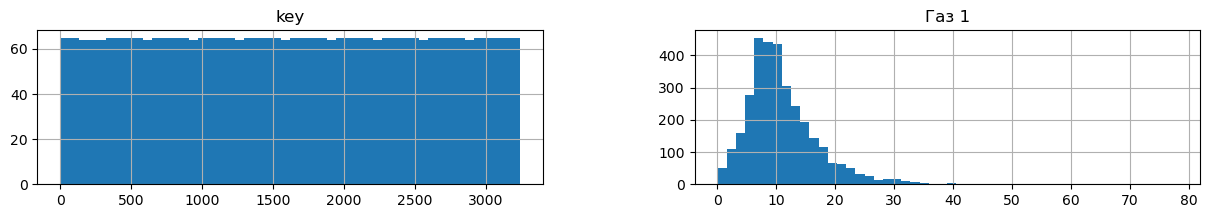

In [11]:
print('Графики распределения параметров в таблице data_gas_new:')
print('По оси Х отложено значение параметра, указанного в заголовке')
print('По оси У количество значений')
data_gas_new.hist(figsize=(15, 2), bins=50)
plt.show()

Содержатся данные об объеме газа, добавленного при обработке каждой партии. Аномальных значений нет, но можно убрать выбросы, значения, которые больше 14.

### Результаты измерения температуры

In [12]:
#data_temp_new.csv — результаты измерения температуры
print('Общая информация')
data_temp_new.info()
display(data_temp_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_temp_new['key'].unique())
print('Уникальных значений в столбце key:', data_temp_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3216


In [13]:
print(data_temp_new['Температура'].describe())

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


Графики распределения параметров в таблице data_temp_new:
По оси Х отложено значение параметра, указанного в заголовке
По оси У количество значений


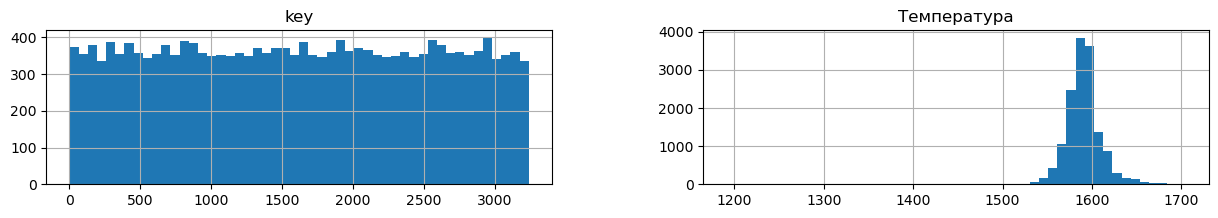

In [14]:
print('Графики распределения параметров в таблице data_temp_new:')
print('По оси Х отложено значение параметра, указанного в заголовке')
print('По оси У количество значений')
data_temp_new.hist(figsize=(15, 2), bins=50)
plt.show()

Содержатся данные о температуре смеси при обработке каждой партии. Есть аномально низкое значение температуры, нужно удалить данные. Удалять нужно всю партию.
Ключи с одним замером удаляем.
Удаляем всю партию с пропусками.


### Данные о проволочных материалах (объём)

In [15]:
#data_wire_new.csv — данные о проволочных материалах (объём)
print('Общая информация')
data_wire_new.info()
display(data_wire_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_wire_new['key'].unique())
print('Уникальных значений в столбце key:', data_wire_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3081


Графики распределения параметров в таблице data_wire_new:
По оси Х отложено значение параметра, указанного в заголовке
По оси У количество значений


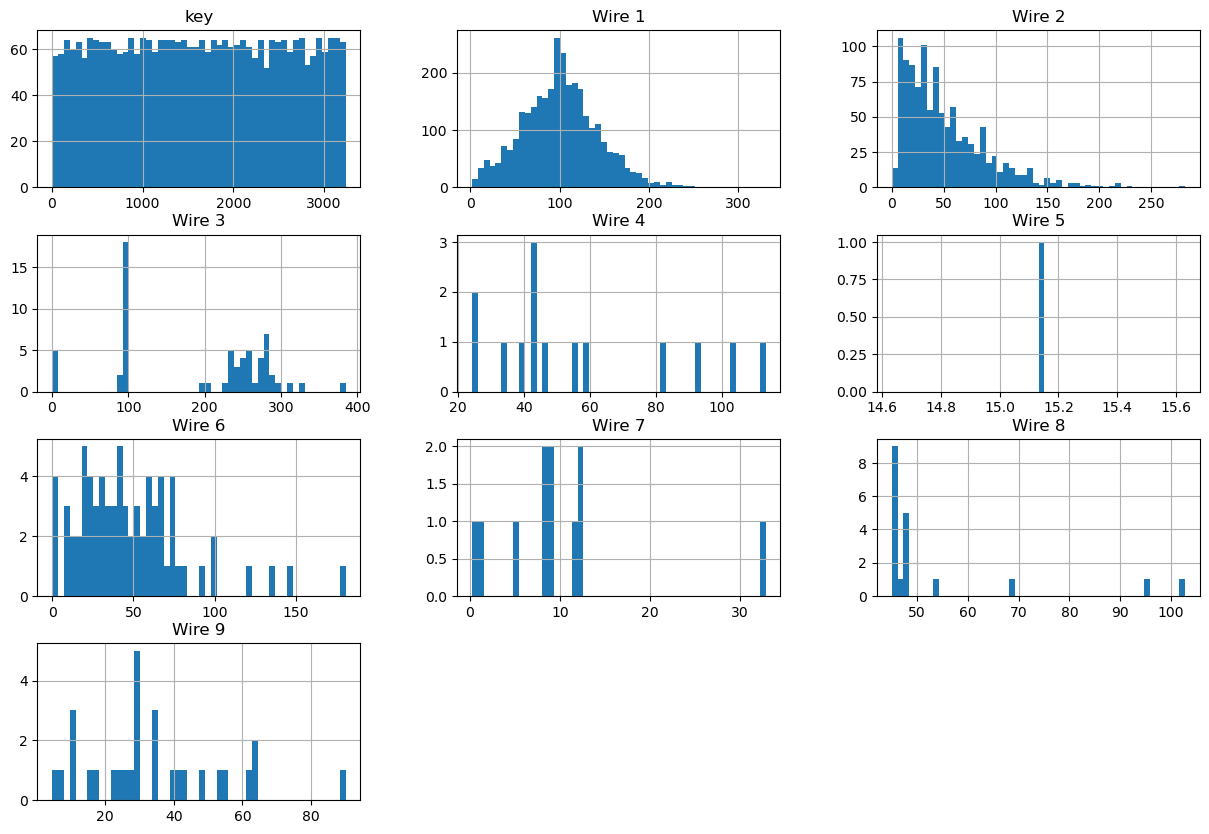

In [16]:
print('Графики распределения параметров в таблице data_wire_new:')
print('По оси Х отложено значение параметра, указанного в заголовке')
print('По оси У количество значений')
data_wire_new.hist(figsize=(15, 10), bins=50)
plt.show()

Содержатся данные об объеме добавленного проволочных материалов для каждой партии (всего 9 типов добавок). Пропуск обозначает, что материал не добавлялся. Чаще всего добавляются №№ 1,2

### Данные о проволочных материалах (время)

In [17]:
#data_wire_time_new.csv — данные о проволочных материалах (время)
print('Общая информация')
data_wire_time_new.info()
display(data_wire_time_new.head())
print()
print('Уникальные значения в столбце key:')
print(data_wire_time_new['key'].unique())
print('Уникальных значений в столбце key:', data_wire_time_new['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Уникальные значения в столбце key:
[   1    2    3 ... 3239 3240 3241]
Уникальных значений в столбце key: 3081


Содержатся данные о том, в какое время добавлен проволочный материал для каждой партии (соответствует таблице с объемами). Пропуск обозначает, что материал не добавлялся.

Не понадобится потому что время, в которое добавлен тот или иной материал не влияет на конечную температару.

### Общий вывод по анализу исходных данных:

1. Датасет data_arc_new. В столбце реактивная мощность - аномальные значения, удаляем, т.к. коллинеарен с активной мощностью. В дальнейшем предлагаю посчитать время нагрева для каждой партии, затем посчитать энергию через активную мощность и время. 
2. Датасет data_bulk_new. Аномалий нет. Перед формированием конечного датасета предлагаю удалить материалы с низкой частотой добавления.
3. Датасет data_bulk_time_new. Не понадобится, т.к. не влияет на конечню температуру
4. Датасет data_gas_new. Аномалий нет, но можно убрать выбросы
5. Датасет data_temp_new. Есть аномально низкое значение температуры, нужно удалить данные о всей партии
6. Датасет data_wire_new. Аномалий нет. Перед формированием конечного датасета предлагаю удалить материалы с низкой частотой добавления.
7. Датасет data_wire_time_new. Не понадобится, т.к. не влияет на конечню температуру

### Бизнес-процесс:
Для каждой партии есть несколько замеров температуры. В зависимости от начальной температуры и от объема добавленной добавки меняется температура плавления (влияет как соотношение объемов материала, так и сами материалы). Исходя из состава и подаваемой энергии необходимо научиться предсказывать конечную температуру смеси.

### План работы:

1. Загрузка данных, обзор. Выявление аномалий
2. Предобработка данных: исправить аномальные значения, заполнить пропуски
3. Создание новых признаков, удаление ненужных
4. Объединение датасетов в общий датасет, на котором будем обучать модели
5. Проверка данных общего датасета
6. Проверка коллинеарности признаков: выше 0.9 удаляем
7. Разбиваем датасет на выборки
8. Масштабирование данных (scaler) на обучающей выборке.
9. Обучаем модели, получение метрики MAE < 6.8 на кросс-валидации
10. Выбираем лучшую, тестируем
11. Сравнение с константной моделью
12. Исследование важности признаков
13. Вывод о проделанной работе

## Подготовка данных

### Датасет data_arc_new:
Реактивная мощность - удалить. Добавить время нагрева, затраченную энергию. В итоге оставить только уникальный номер партии и суммарную затраченную энергию

In [18]:
data_arc_new.info()
data_arc_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [19]:
data_arc_new1 = data_arc_new
data_arc_new1 = data_arc_new1.drop(['Реактивная мощность'], axis=1)
data_arc_new1['Начало нагрева дугой'] = pd.to_datetime(data_arc_new1['Начало нагрева дугой'], format='%Y.%m.%d %H:%M:%S')
data_arc_new1['Конец нагрева дугой'] = pd.to_datetime(data_arc_new1['Конец нагрева дугой'], format='%Y.%m.%d %H:%M:%S')
data_arc_new1['Время нагрева'] = (data_arc_new1['Конец нагрева дугой'] - data_arc_new1['Начало нагрева дугой'])/ np.timedelta64 ( 1 , 's')
data_arc_new1['Энергия'] = data_arc_new1['Активная мощность'] * data_arc_new1['Время нагрева']
data_arc_new1 = data_arc_new1.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Время нагрева'], axis=1)
data_arc_new_final = pd.pivot_table(data_arc_new1, index=['key'], values='Энергия', aggfunc='sum').reset_index()

In [20]:
display(data_arc_new_final.head())
data_arc_new_final.info()
data_arc_new_final.describe()

,key,Энергия
0,1,628.616930
1,2,395.281800
2,3,581.774624
3,4,543.710274
4,5,412.180480


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3214 non-null   int64  
 1   Энергия  3214 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


,key,Энергия
count,3214.000000,3214.000000
mean,1623.061294,527.853965
std,934.739859,248.748621
min,1.000000,26.187544
25%,817.250000,358.783310
50%,1623.500000,498.859124
75%,2431.750000,669.173073
max,3241.000000,3718.054401


In [21]:
data_arc_new_final = data_arc_new_final.loc[data_arc_new_final['Энергия'] < 2000]

In [22]:
display(data_arc_new_final.head())
data_arc_new_final.info()
data_arc_new_final.describe()

,key,Энергия
0,1,628.616930
1,2,395.281800
2,3,581.774624
3,4,543.710274
4,5,412.180480


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3213 non-null   int64  
 1   Энергия  3213 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB


,key,Энергия
count,3213.000000,3213.000000
mean,1623.040772,526.861061
std,934.884631,242.333665
min,1.000000,26.187544
25%,817.000000,358.769152
50%,1623.000000,498.820789
75%,2432.000000,669.147642
max,3241.000000,1906.194897


### Датасет data_temp_new:
Нужно преобразовать дату из текста в формат даты. Есть аномально низкие значения температуры менее 1500, нужно удалить данные о всей партии. Есть пропуски по температуре, сначала заменим заглушкой, после преобразований удалю

In [23]:
data_temp_new.info()
data_temp_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [24]:
data_temp_new = data_temp_new.fillna(9999)

In [25]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'], format='%Y.%m.%d %H:%M:%S')
partia_reset = data_temp_new.loc[data_temp_new['Температура'] < 1500, 'key'].unique()
print('Удалены партии:', partia_reset)
data_temp_new_final = data_temp_new[data_temp_new.key.isin(partia_reset) == False]

Удалены партии: [ 867 1214 1619 2052 2561]


In [26]:
data_temp_new_final = data_temp_new_final.groupby(by='key').agg(['first', 'last']).reset_index()
data_temp_new_final.columns = ['key', 'Время первого замера', 'Время последнего замера', 'Первый замер', 'Последний замер']
data_temp_new_final

,key,Время первого замера,Время последнего замера,Первый замер,Последний замер
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
3206,3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,9999.0
3207,3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,9999.0
3208,3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,9999.0
3209,3240,2019-09-06 15:25:21,2019-09-06 16:35:26,1617.0,9999.0


In [27]:
data_temp_new_final = data_temp_new_final.drop(['Время первого замера', 'Время последнего замера'], axis=1)
data_temp_new_final = data_temp_new_final.loc[data_temp_new_final['Последний замер'] != 9999]
data_temp_new_final = data_temp_new_final.loc[data_temp_new_final['Первый замер'] != 9999]

In [28]:
data_temp_new_final.info()
data_temp_new_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2473 non-null   int64  
 1   Первый замер     2473 non-null   float64
 2   Последний замер  2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


,key,Первый замер,Последний замер
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


### Датасет data_bulk_new:
Удалим данные о материалах с низкой частотой добавления (меньше 100). Заменим пустоту на нули

In [29]:
data_bulk_new.info()
data_bulk_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


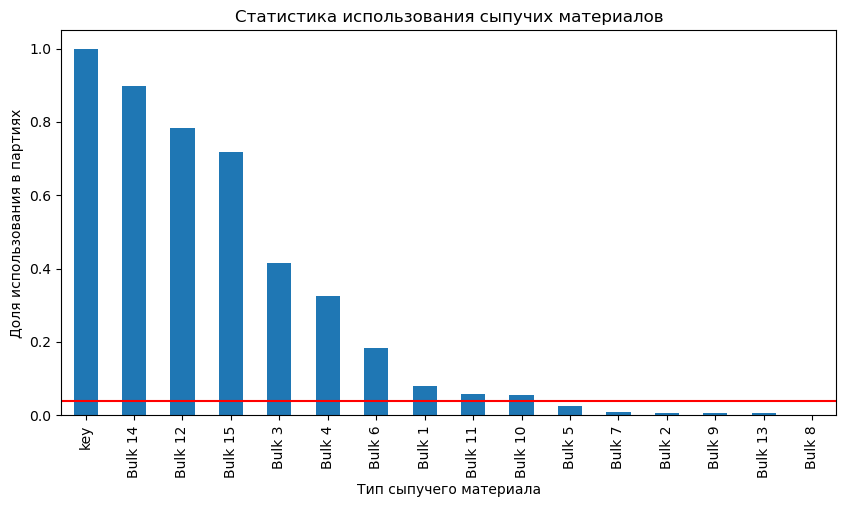

In [30]:
plt.figure(figsize = (10, 5))
ax = (~data_bulk_new.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.04, color='r', linestyle='-')
ax.set_title('Статистика использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')
plt.show()

In [31]:
data_bulk_new_final = data_bulk_new.drop(
    ['Bulk 5', 'Bulk 7', 'Bulk 2', 'Bulk 9', 'Bulk 13', 'Bulk 8'], axis=1)
data_bulk_new_final = data_bulk_new_final.fillna(0)

In [32]:
data_bulk_new_final.info()
data_bulk_new_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 6   3129 non-null   float64
 5   Bulk 10  3129 non-null   float64
 6   Bulk 11  3129 non-null   float64
 7   Bulk 12  3129 non-null   float64
 8   Bulk 14  3129 non-null   float64
 9   Bulk 15  3129 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 244.6 KB


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0


### Датасет data_wire_new:
Удалим данные о материалах с низкой частотой добавления (меньше 100). Заменим пустоту на нули

In [33]:
data_wire_new.info()
data_wire_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


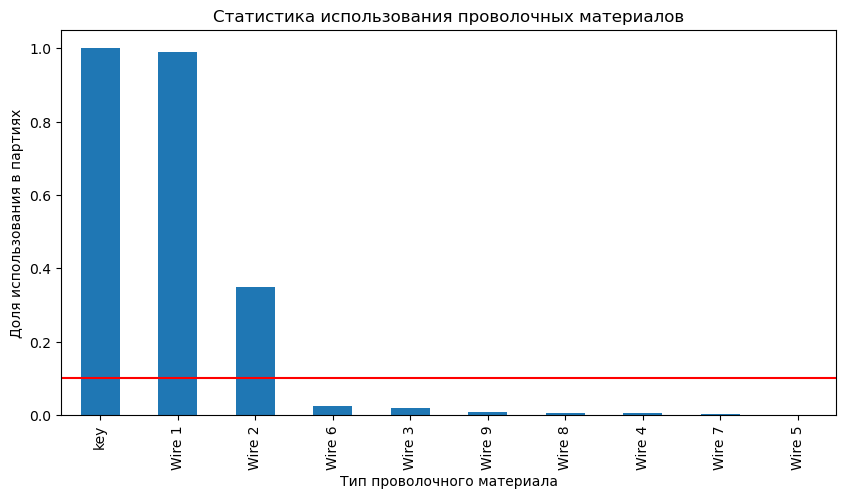

In [34]:
plt.figure(figsize = (10, 5))
ax = (~data_wire_new.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')
plt.show()

In [35]:
data_wire_new_final = data_wire_new.drop(['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)
data_wire_new_final = data_wire_new_final.fillna(0)

In [36]:
data_wire_new_final.info()
data_wire_new_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


### Объединим в один датасет:


In [37]:
data = data_temp_new_final.merge(data_arc_new_final, on='key', how='inner')
data = data.merge(data_bulk_new_final, on='key', how='inner')
data = data.merge(data_gas_new, on='key', how='inner')
data = data.merge(data_wire_new_final, on='key', how='inner')

In [38]:
print('Общая информация')
data.info()
display(data.head())
print()
print('Уникальные значения в столбце key:')
print(data['key'].unique())
print('Уникальных значений в столбце key:', data['key'].nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2324 non-null   int64  
 1   Первый замер     2324 non-null   float64
 2   Последний замер  2324 non-null   float64
 3   Энергия          2324 non-null   float64
 4   Bulk 1           2324 non-null   float64
 5   Bulk 3           2324 non-null   float64
 6   Bulk 4           2324 non-null   float64
 7   Bulk 6           2324 non-null   float64
 8   Bulk 10          2324 non-null   float64
 9   Bulk 11          2324 non-null   float64
 10  Bulk 12          2324 non-null   float64
 11  Bulk 14          2324 non-null   float64
 12  Bulk 15          2324 non-null   float64
 13  Газ 1            2324 non-null   float64
 14  Wire 1           2324 non-null   float64
 15  Wire 2           2324 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 308.

,key,Первый замер,Последний замер,Энергия,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
0,1,1571.0,1613.0,628.616930,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
1,2,1581.0,1602.0,395.281800,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
2,3,1596.0,1599.0,581.774624,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
3,4,1601.0,1625.0,543.710274,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
4,5,1576.0,1602.0,412.180480,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456



Уникальные значения в столбце key:
[   1    2    3 ... 2497 2498 2499]
Уникальных значений в столбце key: 2324


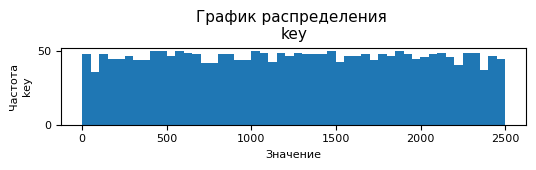

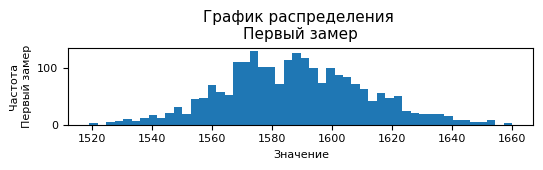

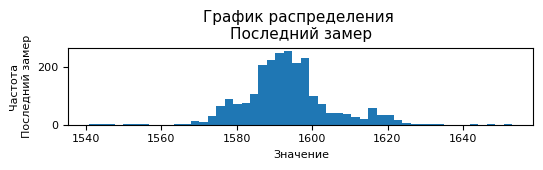

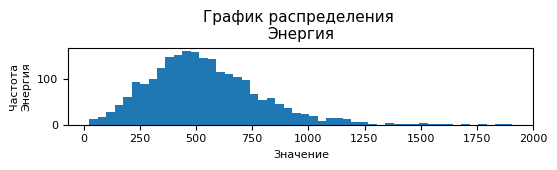

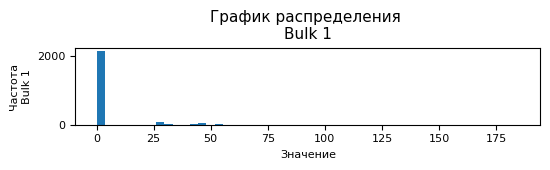

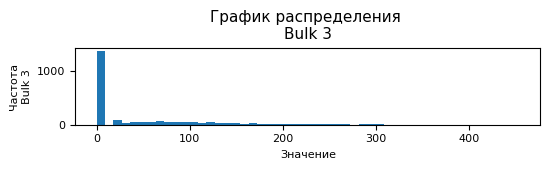

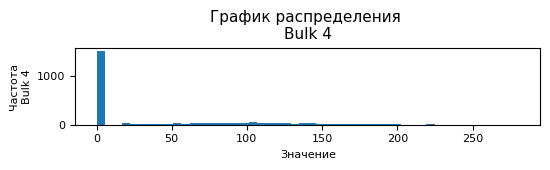

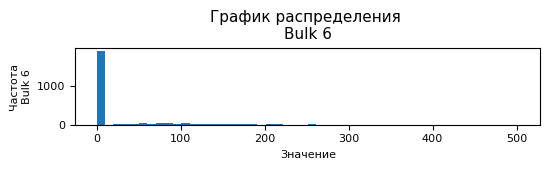

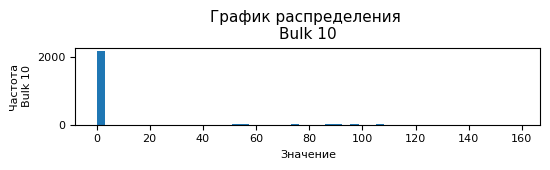

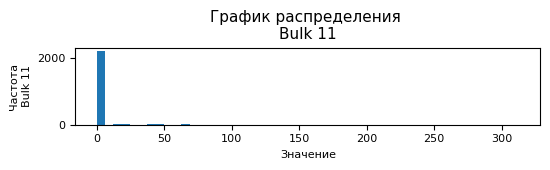

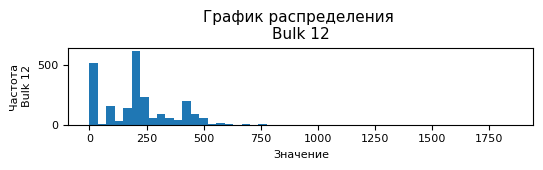

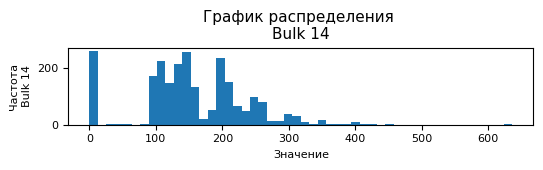

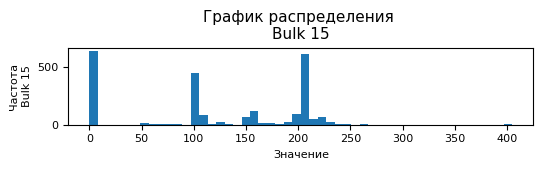

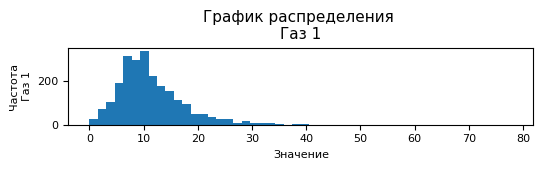

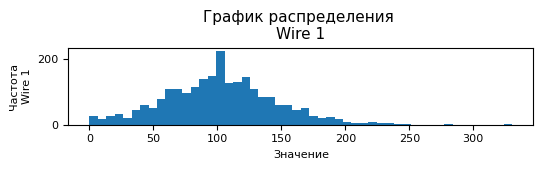

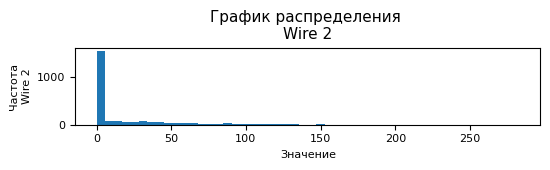

In [40]:
for col in data.columns:
    data[col].plot(kind='hist', bins=50, figsize=(6, 1), fontsize=8)
    plt.xlabel('Значение', fontsize=8)
    plt.ylabel('Частота \n'+ col, fontsize=8)
    plt.title('График распределения \n' + col, fontsize=11)
    #plt.fontsize(5)
    plt.show()

### Проверка коллинеарности:


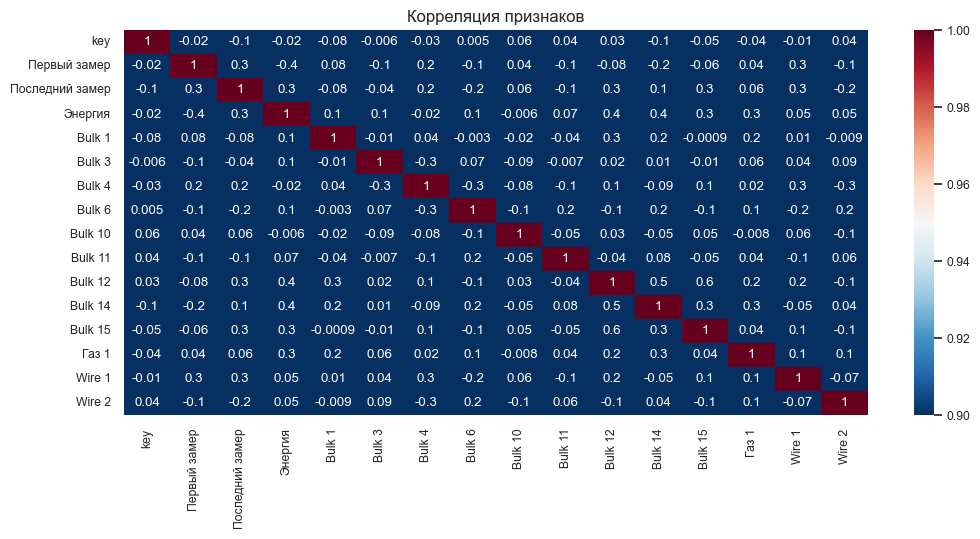

In [41]:
sns.set(font_scale=0.8)
plt.figure(figsize=(12, 5))
plt.title('Корреляция признаков', fontsize=12)
sns.heatmap(
    data.corr(), 
    fmt='.1g',
    cmap='RdBu_r', 
    annot=True, 
    vmin=0.9, vmax=1);

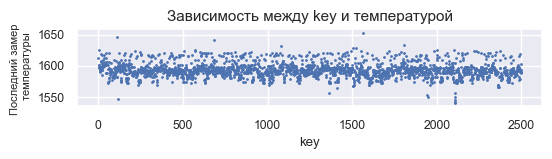

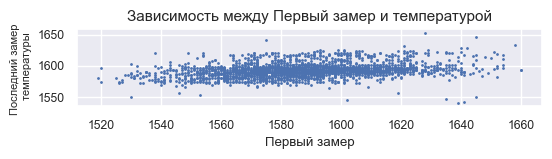

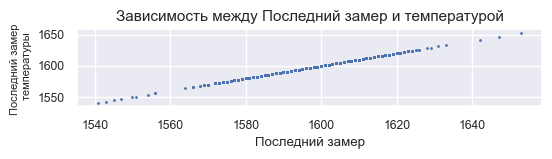

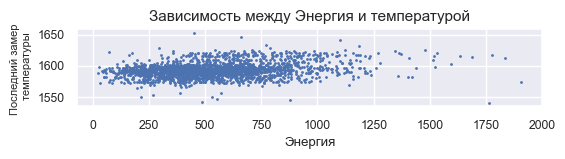

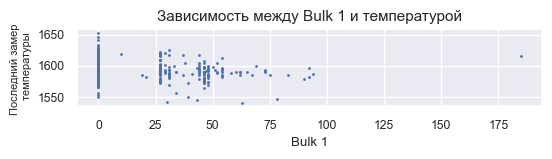

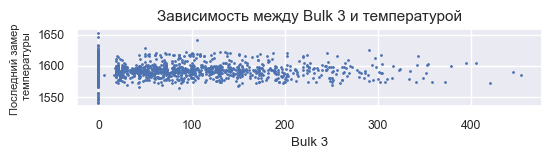

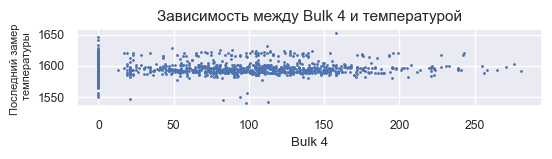

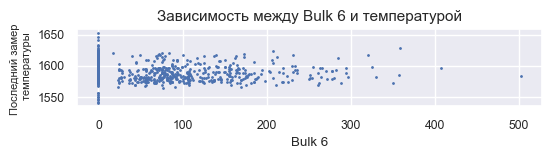

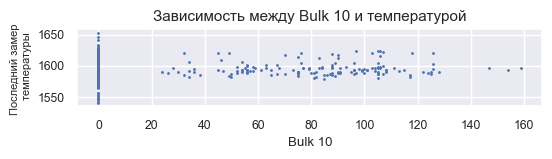

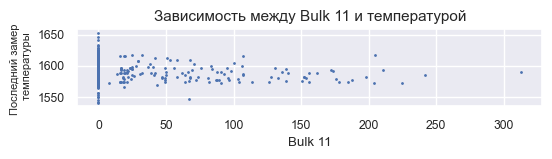

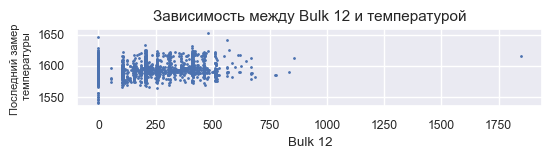

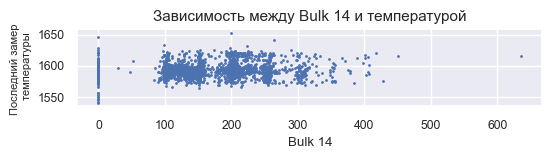

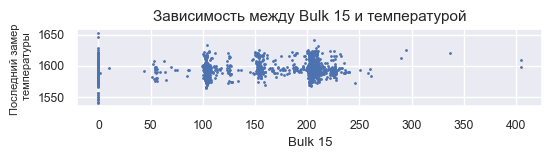

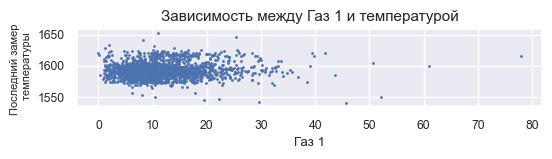

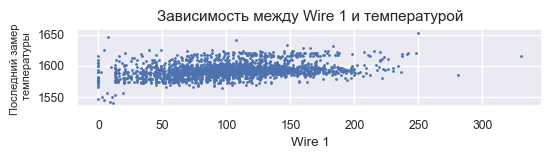

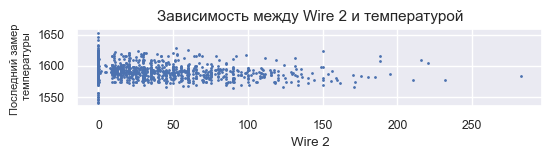

In [42]:
for col in data.columns:
    plt.figure(figsize=(6, 1))
    plt.scatter(x=data[col], y=data['Последний замер'], s=1)
    plt.xlabel(col)
    plt.ylabel('Последний замер \n температуры', fontsize=8)
    plt.title('Зависимость между ' + col + ' и температурой', fontsize=11)
    plt.show()

Последний замер температуры (target) сильно зависит от начальной температуры, коэффициент = 1. Удалять ничего не будем

### Разбиение данных на обучающую и тестовую выборки:
Удалим столбец key, он не влияет на обучение

In [43]:
target = data['Последний замер']
features = data.drop(['key', 'Последний замер'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=r_state)


print('Тренировочная выборка:', len(target_train))
print('Тестовая выборка:', len(target_test))

Тренировочная выборка: 1743
Тестовая выборка: 581


### Масштабирование данных:

In [44]:
features_train_scaled = features_train
features_test_scaled = features_test
print(features_train_scaled.shape)

scaler = StandardScaler()
scaler.fit(features_train_scaled)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

print(features_train_scaled.shape)

(1743, 14)
(1743, 14)


## Обучение моделей:

### Модель линейной регрессии:

In [45]:
model_lin = LinearRegression()
grid_space = {'fit_intercept': [True, False]}

grid_lin = GridSearchCV(model_lin, grid_space, cv=5, scoring='neg_mean_absolute_error')
model_grid_lin = grid_lin.fit(features_train_scaled, target_train)

print('Лучшие гиперпараметры линейной модели: '+str(model_grid_lin.best_params_))
print('Лучший MAE линейной модели: '+str(abs(model_grid_lin.best_score_)))

Лучшие гиперпараметры линейной модели: {'fit_intercept': True}
Лучший MAE линейной модели: 6.599813760425944


### Модель LGBMRegressor:

In [46]:
model_lgbm = LGBMRegressor(random_state=r_state)

grid_space={'max_depth':[3, 4, 5, 10],
              'n_estimators':[48, 50, 51, 56],
            'learning_rate': [0.09, 0.1, 0.11]
           }

grid_lgbm = RandomizedSearchCV(model_lgbm, param_distributions=grid_space, cv=5, scoring='neg_mean_absolute_error')
model_grid_lgbm = grid_lgbm.fit(features_train_scaled, target_train)

print('Лучшие гиперпараметры lgbm: '+str(model_grid_lgbm.best_params_))
print('Лучший MAE lgbm: '+str(abs(model_grid_lgbm.best_score_)))

Лучшие гиперпараметры lgbm: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.09}
Лучший MAE lgbm: 6.477521694810396


### Модель CatBoostRegressor:

In [47]:
model_cat = CatBoostRegressor(random_state=r_state, verbose=0)

grid_space = {'depth': [3, 4, 5],  
                'n_estimators': [5, 8, 10, 12],
                'learning_rate': [0.2, 0.5, 0.6]
             }
grid_cat = RandomizedSearchCV(model_cat, param_distributions=grid_space, cv=5, scoring='neg_mean_absolute_error')
model_grid_cat = grid_cat.fit(features_train_scaled, target_train)

print('Лучшие гиперпараметры cat: '+str(model_grid_cat.best_params_))
print('Лучший MAE cat: '+str(abs(model_grid_cat.best_score_)))

Лучшие гиперпараметры cat: {'n_estimators': 12, 'learning_rate': 0.5, 'depth': 5}
Лучший MAE cat: 6.642522757424736


### Проверка лучшей модели на тестовой выборке:

In [48]:
#model = LGBMRegressor(random_state=r_state, n_estimators=51, max_depth=4, learning_rate=0.1)
#model.fit(features_train_scaled, target_train)
#predict_test = model.predict(features_test_scaled)

#mae = mean_absolute_error(predict_test, target_test)
#print('mae test = ', mae)

In [49]:
model = grid_lgbm.best_estimator_
predict_test = model.predict(features_test_scaled)

mae = mean_absolute_error(predict_test, target_test)
print('mae test = ', mae)

mae test =  6.751499279264292


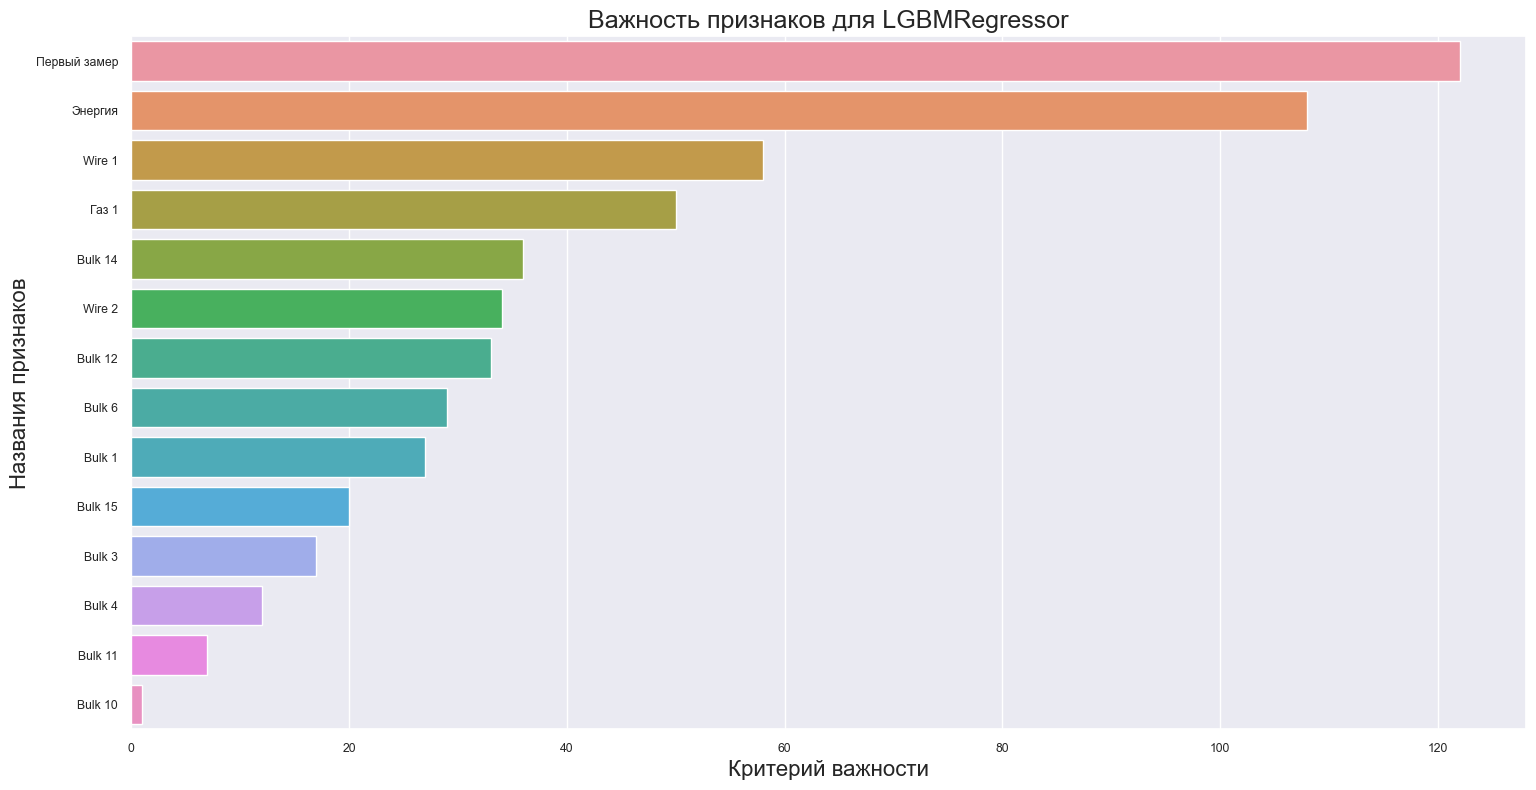

In [50]:
plot_data = {
    'features': features_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
sns.set(font_scale=1.1)
plt.title('Важность признаков для LGBMRegressor', fontsize=18)
plt.xlabel('Критерий важности', fontsize=16)
plt.ylabel('Названия признаков', fontsize=16)
plt.show()

### Сравнение с дамми-моделью:

In [51]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_scaled, target_train)
answer_dummy = dummy_regr.predict(features_test_scaled)
mae_dummy = mean_absolute_error(answer_dummy, target_test)
print('mae для Dummy модели = ', mae_dummy)

mae для Dummy модели =  8.187488088572636


### Вывод:
Обучено 3 модели машинного обучения: линейной регрессии, LGBMRegressor, CatBoostRegressor.  Лучшей оказалась модель LGBMRegressor.

Значение MAE на тестовой выборке составило 6.7, что удовлетворяет требованиям заказчика

Проанализировано влияние признаков, наибольшее влияние оказывают начальная температура смеси и затраченная энергия

Выполнено сравнение с dummy-моделью. МАЕ для dummy-модели ниже

## Отчет

### Сопоставление фактического решения с плановым

Основные пункты выполнены согласно намеченному плану, отклонений нет.

### Трудности проекта

Понять технологический процесс плавления стали, исходя из этого верно выполнить анализ исходных данных, корректно обработать аномалии

### Ключевые шаги:

#### Обработка данных:

В наше распоряжение предоставлено 7 датасетов, содержащих информацию о технологическом процессе на разных этапах:

1. Датасет data_arc_new. Содержит данные о времени начала и конца нагрева смеси и затраченной мощности для нагрева каждой партии. В столбце реактивная мощность - аномальные, отрицательные значения. Эти данные были удалены. Далее для каждой партии была посчитана суммарная энергия, затраченная на нагрев.
2. Датасет data_bulk_new. Содержит информацию об объеме добавленного сыпучего материала. Аномалий нет. Перед формированием конечного датасета были удалены материалы с низкой частотой добавления, которые встречались в менее 4% случаях.
3. Датасет data_bulk_time_new. Содержит информацию о времени, во сколько был добавлен сыпучий материал каждого типа. Датасет не понадобится, т.к. не влияет на конечную температуру
4. Датасет data_gas_new. Содержит информацию об объеме газа, затраченного при продувке. Аномалий нет. Корректировок не было.
5. Датасет data_temp_new. Содержит информацию о температуре смеси на каждом этапе. Найдено аномально низкое значение температуры, данные о всей партии были удалены. Далее были выбраны начальная и конечная температура для каждой партии. Для некоторых партий был только один замер температуры, такие данные также были удалены. **Конечная температура - таргет для обучения моделей.**
6. Датасет data_wire_new. Содержит информацию об объеме добавленного проволочного материала. Аномалий нет. Перед формированием конечного датасета были удалены материалы с низкой частотой добавления, которые встречались в менее 10% случаях.
7. Датасет data_wire_time_new. Содержит информацию о времени, во сколько был добавлен проволочный материал каждого типа. Датасет не понадобится, т.к. не влияет на конечную температуру

Из оставшихся данных был сформирован и проанализирован итоговый датасет, в который вошли следующие данные:
1.   Первый замер     2324 non-null   float64
2.   Последний замер  2324 non-null   float64
3.   Энергия          2324 non-null   float64
4.   Bulk 1           2324 non-null   float64
5.   Bulk 3           2324 non-null   float64
6.   Bulk 4           2324 non-null   float64
7.   Bulk 6           2324 non-null   float64
8.   Bulk 10          2324 non-null   float64
9.   Bulk 11          2324 non-null   float64
10.  Bulk 12          2324 non-null   float64
11.  Bulk 14          2324 non-null   float64
12.  Bulk 15          2324 non-null   float64
13.  Газ 1            2324 non-null   float64
14.  Wire 1           2324 non-null   float64
15.  Wire 2           2324 non-null   float64

Эти данные были разбиты на обучающую и тестовую выборки (при разбиении использовался random state = 110923)

Далее, выполнено масштабирование данных при помощи StandardScaler

#### Обучение моделей:

- Для обучения выбраны три модели: линейной регрессии, LGBMRegressor, CatBoostRegressor. 
- Гиперпараметры подбирались на кросс-валидации (GridSearchCV) с количеством фолдов = 5, random state для каждой модели = 110923
- Целевая метрика — средняя абсолютная ошибка (MAE) рассчитывается как сумма абсолютных ошибок, делённая на размер выборки.
- Лучшей моделью оказалась модель LGBMRegressor со следующими гиперпараметрами: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.09 'random state': 110923}

#### Тестирование лучшей модели:

Для тестовой выборки применена модель LGBMRegressor с лучшими гиперпарметрами, МАЕ для теста составил 6.75, что удовлетворяет условиям заказчика

### Рекомендации по улучшению:

Для улучшения можно увеличить размер выборки или восстановить данные в текущих датасетах